# **PROJET ACCIDENTOLOGIE USAGERS : KAGGLE ESIEE 2023 - 2024**

# **OUVERTURE DES FICHIERS**

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [161]:
pd.set_option('display.max_columns', None)

In [162]:
def open_file(item):
    # Création d'un DataFrame vide pour accumuler les données
    all_data = pd.DataFrame()

    # Boucle sur chaque année
    for annee in range(2012, 2023):
        path = f"TRAIN/BAAC-Annee-{annee}/{item}_{annee}_.csv"
        try:
            # Lecture du fichier CSV
            file = pd.read_csv(path, delimiter=';', index_col = 0,low_memory=False)
            # Concaténation du fichier lu avec le DataFrame global
            all_data = pd.concat([all_data, file])
        except FileNotFoundError:
            print(f"Le fichier {path} n'a pas été trouvé.")
        except Exception as e:
            print(f"Erreur lors de la lecture du fichier {path}: {e}")

    return all_data

In [163]:
def create_dataframe():

    caracteristiques = open_file('caracteristiques')
    lieux = open_file('lieux')
    usagers = open_file('usagers')
    vehicules = open_file('vehicules')

    return caracteristiques,lieux,usagers,vehicules

In [164]:
caracteristiques,lieux,usagers,vehicules = create_dataframe()

### **Isolation de la colonne Grave**

In [165]:
# Convertir la colonne 'grav' en array numpy
grav_array = usagers['grav'].values
num_acc_array = usagers['Num_Acc'].values

# Créer un array pour la présence de 'GRAVE'
is_grave = np.isin(grav_array, [2, 3])

# Utiliser ufuncs de numpy pour créer un mapping de 'Num_Acc' à 'GRAVE'
unique_nums, grave_presence = np.unique(num_acc_array, return_inverse=True)
result = np.bitwise_or.reduceat(is_grave, np.r_[0, np.where(np.diff(num_acc_array))[0]+1])

In [166]:
usagers.drop('grav',axis = 1,inplace = True)

In [167]:
# Création du DataFrame
df_grave = pd.DataFrame({
    'Num_Acc': unique_nums,
    'GRAVE': result
})

df_grave['GRAVE'] = df_grave['GRAVE'].astype(int)

### **Merge GRAVE + Dataframe :** 

In [168]:
def merge_grave(df):

    return df_grave.merge(df,on = "Num_Acc",how = 'left')

### **Fonction Analyse :**

In [169]:
def summary_info(df):

    # Créer un nouveau DataFrame avec ces comptages
    return  pd.DataFrame({
        'NaN_Count': df.isna().sum().astype(int),
        'Nan_ratio': df.isna().mean().astype(float),
        '-1_Count': df.eq(-1).sum().astype(int),
        '0_Count': df.eq(0).sum().astype(int)
    })

In [170]:
usagers = merge_grave(usagers)

## **ANALYSE USAGERS :**

In [171]:
usagers_naive = usagers.copy()

In [172]:
def usagers_del_(df):

    col_to_drop = ['id_vehicule','id_usager','secu2','secu3']
    df = df.drop(col_to_drop,axis = 1)

    return df

In [173]:
def usagers_NaN_(df):

    col_to_replace = ['place','trajet']

    df[col_to_replace] = df[col_to_replace].replace(np.nan,-1)
    
    return df

In [174]:
def usagers_correction_(df):

    df['locp'] = df['locp'].replace(9,-1)
    df['trajet'] = df['trajet'].replace(0,-1)

    # Calcul de la médiane en excluant les NaN
    median_an_nais = df['an_nais'].median()

    # Remplacement des NaN par la médiane dans la colonne 'an_nais'
    df['an_nais'].fillna(median_an_nais, inplace=True)

    

    return df

In [175]:
def pieton_correction_(df):

     # Remplacement conditionnel des valeurs
    condition_3 = (df['catu'] == 3) & df['locp'].isna() & df['actp'].isna() & df['etatp'].isna()

    # Condition pour catu != 3 et toutes les valeurs pertinentes sont NaN
    condition_not_3 = (df['catu'] != 3) & df['locp'].isna() & df['actp'].isna() & df['etatp'].isna()

    # Appliquer les conditions pour les trois colonnes
    df.loc[condition_3, ['locp', 'actp', 'etatp']] = -1
    df.loc[condition_not_3, ['locp', 'actp', 'etatp']] = 0

    col_to_replace = ['locp','actp','etatp']

    df[col_to_replace] = df[col_to_replace].replace(np.nan,-1)

    return df

In [176]:
def adjust_secu(value):
    if value in [1, 2, 3, 4, 9]:
        return -1
    elif value >= 10:
        tens = int(value // 10)
        units = int(value % 10)
        if units == 1:
            return tens
        elif units == 3:
            return 3
        elif units == 2:
            return 0
        else:
            return value  # Si aucune des autres conditions n'est rencontrée, renvoyer la valeur originale
    else:
        return value  # Pour les cas négatifs et autres cas non définis

def merge_columns(df):
    
    df['secu'] = df['secu'].fillna(df['secu1'])
    df['secu'] = df['secu'].replace([9,4,6,5,7],0)
    df['secu'] = df['secu'].fillna(-1)
    df.drop(['secu1'],axis = 1,inplace= True)
    
    return df

In [177]:
def usagers_preprocessing_(df):

    df = usagers_del_(df)
    df = usagers_NaN_(df)
    df = pieton_correction_(df)
    df = usagers_correction_(df)

    df['secu'] = df['secu'].apply(adjust_secu)
    df = merge_columns(df)

    cols_to_convert_category = ['place','catu','sexe','trajet','secu','locp','actp','etatp','num_veh']

    df[cols_to_convert_category] = df[cols_to_convert_category].astype('category')

    return df

In [178]:
usagers_naive = usagers_preprocessing_(usagers_naive)

# **TRAINING MODEL :**

In [179]:
from sklearn.model_selection import train_test_split

In [180]:
X = usagers_naive.drop(['Num_Acc','GRAVE'],axis = 1)
y = usagers_naive['GRAVE']

In [181]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [182]:
def importance_values(feature_imp_df):

    # Visualisation avec un graphique à barres
    plt.figure(figsize=(10, 6))
    plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Variables')
    plt.title('Importance des variables dans le modèle LightGBM')
    plt.gca().invert_yaxis()  # Inverser l'axe y pour avoir la variable la plus importante en haut
    plt.show()

In [183]:
def loss_curve(evals_result):

    # Extraction des scores L1 pour les ensembles de train et de test
    train_l1 = evals_result['training']['l1']
    test_l1 = evals_result['valid_1']['l1']

    # Création du graphique
    plt.figure(figsize=(10, 6))
    plt.plot(train_l1, label='Train')
    plt.plot(test_l1, label='Test')
    plt.title('Courbe d\'apprentissage du modèle LightGBM')
    plt.xlabel('Nombre d\'itérations')
    plt.ylabel('L1 Loss')
    plt.legend()
    plt.show()

In [184]:
def auc_curve(evals_result):

    train_auc = evals_result['training']['auc']
    test_auc = evals_result['valid_1']['auc']

    # Graphique pour AUC
    plt.figure(figsize=(10, 6))
    plt.plot(train_auc, label='Train AUC')
    plt.plot(test_auc, label='Test AUC')
    plt.title('Évolution de l\'AUC au fil des itérations')
    plt.xlabel('Nombre d\'itérations')
    plt.ylabel('AUC')
    plt.legend()

In [185]:
def training_model(model,X,y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    evals_result = {}

    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric=['auc', 'l1'])

    y_pred_proba_lgb = model.predict_proba(X_test)[:, 1]
    auc_lgb = roc_auc_score(y_test, y_pred_proba_lgb)
    print("AUC LightGBM:", auc_lgb)

    # Extraction des importances des variables
    feature_importances = model.feature_importances_

    evals_result = model.evals_result_

    feature_imp_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    importance_values(feature_imp_df)
    loss_curve(evals_result)
    auc_curve(evals_result)

    return feature_imp_df

In [186]:
lgb_model = lgb.LGBMClassifier(enable_categorical = True,learning_rate = 0.01,verbose = -1,n_estimators = 200,objective='binary')

In [187]:
#feature_imp_df = training_model(lgb_model,X,y)

# **FEATURE ENGINEERING :**

In [188]:
def create_age(df):

    # Calcul de la médiane pour la colonne 'an_nais' en ignorant les valeurs NaN
    median_an_nais = df['an_nais'].median()

    # Remplacement des NaN par la médiane dans la colonne 'an_nais'
    df['an_nais'].fillna(median_an_nais, inplace=True)

    
    df['an_nais'] = df['an_nais'].astype(int)
    df['age'] = df['Num_Acc'].astype(str).str[:4].astype(int) - df['an_nais']

    df['age'] = df['age'].astype(int)
    
    return df

In [189]:
def create_catu(df):

    df['total_usagers'] = df.groupby('Num_Acc')['Num_Acc'].transform('count')
    
    df['nb_conducteurs'] = df['catu'].eq(1).groupby(df['Num_Acc']).transform('sum').astype(int)
    df['nb_passagers'] = df['catu'].eq(2).groupby(df['Num_Acc']).transform('sum').astype(int)

    df['ratio_conducteurs'] = df['nb_conducteurs'] / df['total_usagers']
    df['ratio_passagers'] = df['nb_passagers'] / df['total_usagers']
    
    return df

In [190]:
def secu_catu(df):

    # 1. Groupby sur la colonne "Num_Acc" et compter les conducteurs avec ceinture
    nombre_conducteur_avec_ceinture = df[df['secu'] == 1 & (df['catu'] == 1)].groupby('Num_Acc').size().reset_index(name='nombre_conducteur_avec_ceinture')

    # 2. Fusionner les résultats avec ton DataFrame initial
    df = pd.merge(df, nombre_conducteur_avec_ceinture, on='Num_Acc', how='left')

    # 1. Groupby sur la colonne "Num_Acc" et compter les conducteurs avec ceinture
    nombre_passager_avec_ceinture = df[df['secu'] == 1 & (df['catu'] == 2)].groupby('Num_Acc').size().reset_index(name='nombre_passagers_avec_ceinture')

    # 2. Fusionner les résultats avec ton DataFrame initial
    df = pd.merge(df, nombre_passager_avec_ceinture, on='Num_Acc', how='left')

    df[['nombre_conducteur_avec_ceinture','nombre_passagers_avec_ceinture']] = df[['nombre_conducteur_avec_ceinture','nombre_passagers_avec_ceinture']].fillna(0)

    return df

In [191]:
def column_aggreg(df,column):

    # One-hot encoding sur la colonne "trajet"
    one_hot_trajet = pd.get_dummies(df[column], prefix= column)

    # Ajouter la colonne Num_Acc pour pouvoir fusionner les résultats plus tard
    one_hot_trajet['Num_Acc'] = df['Num_Acc']

    # Aggrégation des résultats pour chaque accident
    one_hot_trajet_grouped = one_hot_trajet.groupby('Num_Acc').sum().reset_index()

    # Fusionner ces résultats avec ton DataFrame initial
    df = pd.merge(df, one_hot_trajet_grouped, on='Num_Acc', how='left')

    # Si certains accidents n'ont pas de valeurs pour certains trajets, remplis les valeurs manquantes par 0
    columns_to_fill = [col for col in one_hot_trajet_grouped.columns if col.startswith(f'{column}_')]
    df[columns_to_fill] = df[columns_to_fill].fillna(0)

    return df

In [192]:
def count_sexe(df):
    # Grouper par 'Num_Acc' et compter les occurrences de chaque sexe
    count_sexe = df.groupby('Num_Acc')['sexe'].value_counts().unstack(fill_value=0)

    # Renommer les colonnes pour plus de clarté
    count_sexe.columns = ['nb_hommes', 'nb_femmes','nb_inconnue']

    # Rejoindre avec le DataFrame original
    return df.merge(count_sexe, left_on='Num_Acc', right_index=True)

In [193]:
def age_annais(df):

    # Groupby Num_Acc et calcul des moyennes
    grouped = df.groupby('Num_Acc')
    mean_age = grouped['age'].mean()
    mean_an_nais = grouped['an_nais'].mean()

    # Création de nouvelles colonnes dans le DataFrame original pour les moyennes
    df['age'] = df['Num_Acc'].map(mean_age)
    df['an_nais'] = df['Num_Acc'].map(mean_an_nais)
    
    return df

In [194]:
def feature_engineering(df):

    df = usagers_preprocessing_(df)

    df = create_age(df)
    df = create_catu(df)
    df = secu_catu(df)
    df = count_sexe(df)
    df = column_aggreg(df,'secu')
    df = column_aggreg(df,'trajet')
    df = column_aggreg(df,'place')
    df = column_aggreg(df,'actp')
    df = column_aggreg(df,'locp')
    df = column_aggreg(df,'etatp')
    df = age_annais(df)

    col_to_drop = ['secu','trajet','place','sexe','actp','locp','etatp','num_veh','catu','nb_inconnue']

    df = df.drop(col_to_drop,axis = 1)

    df = df.drop_duplicates(subset='Num_Acc', keep='first')
    
    return df

In [195]:
usagers_fe = usagers.copy()

usagers_fe = feature_engineering(usagers_fe)

# **TRAINING MODEL USAGERS :**

In [196]:
X = usagers_fe.drop(['Num_Acc','GRAVE'],axis = 1)
y = usagers_fe['GRAVE']

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

AUC LightGBM: 0.6975110233017408


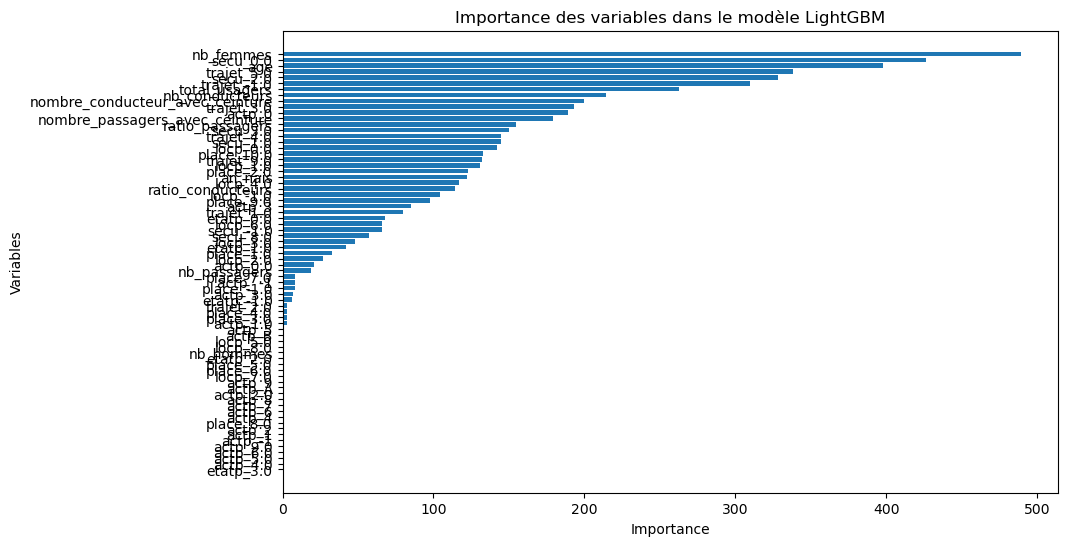

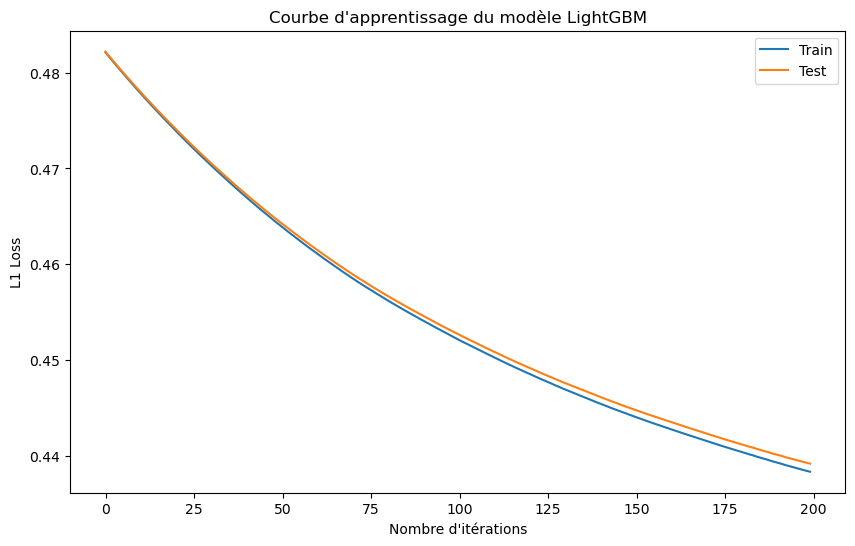

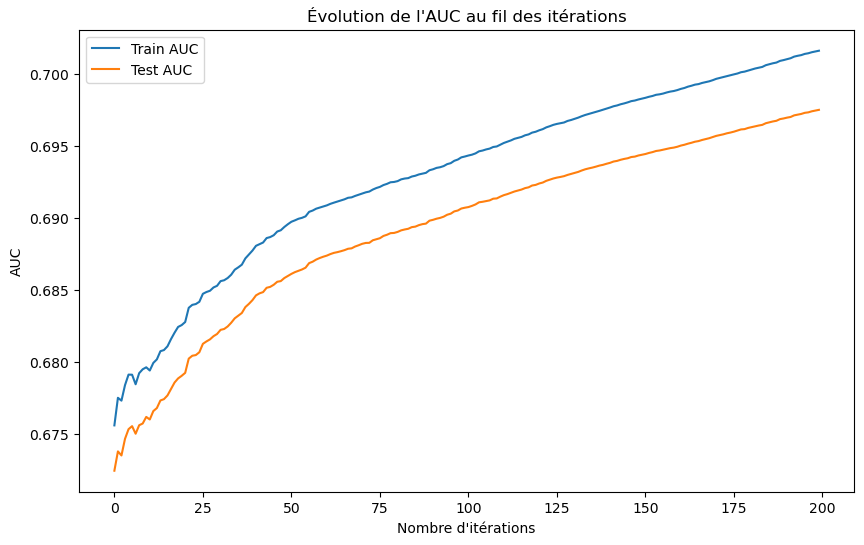

In [198]:
feature_imp_df = training_model(lgb_model,X,y)

In [199]:
feature_imp_df.T

,10,12,1,22,14,17,2,3,7,20,45,8,6,15,21,13,58,34,23,59,26,0,62,5,57,33,48,18,68,64,11,16,61,69,25,60,36,4,31,44,24,39,67,19,28,27,37,50,56,63,66,9,70,29,30,65,54,55,38,53,52,51,49,32,47,46,35,43,42,41,40,71
Feature,nb_femmes,secu_0.0,age,trajet_5.0,secu_2.0,trajet_-1.0,total_usagers,nb_conducteurs,nombre_conducteur_avec_ceinture,trajet_3.0,actp_0,nombre_passagers_avec_ceinture,ratio_passagers,secu_3.0,trajet_4.0,secu_1.0,locp_0.0,place_10.0,trajet_9.0,locp_1.0,place_2.0,an_nais,locp_4.0,ratio_conducteurs,locp_-1.0,place_9.0,actp_3,trajet_1.0,etatp_0.0,locp_6.0,secu_-1.0,secu_8.0,locp_3.0,etatp_1.0,place_1.0,locp_2.0,actp_0.0,nb_passagers,place_7.0,actp_ -1,place_-1.0,actp_3.0,etatp_-1.0,trajet_2.0,place_4.0,place_3.0,actp_1.0,actp_5,actp_B,locp_5.0,locp_8.0,nb_hommes,etatp_2.0,place_5.0,place_6.0,locp_7.0,actp_9,actp_A,actp_2.0,actp_8,actp_7,actp_6,actp_4,place_8.0,actp_2,actp_1,actp_-1,actp_9.0,actp_6.0,actp_5.0,actp_4.0,etatp_3.0
Importance,489,426,398,338,328,310,263,214,200,193,189,179,155,150,145,145,142,133,132,131,123,122,117,114,104,98,85,80,68,66,66,57,48,42,33,27,21,19,8,8,8,7,6,3,3,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [201]:
usagers_fe_clean = usagers_fe.copy()

In [202]:
best_features = feature_imp_df[feature_imp_df['Importance'] > 50]

In [203]:
X = usagers_fe_clean[best_features['Feature'].to_list()]
y = usagers_fe_clean['GRAVE']

In [204]:
best_features.T

,10,12,1,22,14,17,2,3,7,20,45,8,6,15,21,13,58,34,23,59,26,0,62,5,57,33,48,18,68,64,11,16
Feature,nb_femmes,secu_0.0,age,trajet_5.0,secu_2.0,trajet_-1.0,total_usagers,nb_conducteurs,nombre_conducteur_avec_ceinture,trajet_3.0,actp_0,nombre_passagers_avec_ceinture,ratio_passagers,secu_3.0,trajet_4.0,secu_1.0,locp_0.0,place_10.0,trajet_9.0,locp_1.0,place_2.0,an_nais,locp_4.0,ratio_conducteurs,locp_-1.0,place_9.0,actp_3,trajet_1.0,etatp_0.0,locp_6.0,secu_-1.0,secu_8.0
Importance,489,426,398,338,328,310,263,214,200,193,189,179,155,150,145,145,142,133,132,131,123,122,117,114,104,98,85,80,68,66,66,57


In [205]:
lgb_model = lgb.LGBMClassifier(enable_categorical = True,verbose = -1,objective='binary',learning_rate = 0.005,n_estimators = 800, num_leaves  = 25)

AUC LightGBM: 0.702958411878129


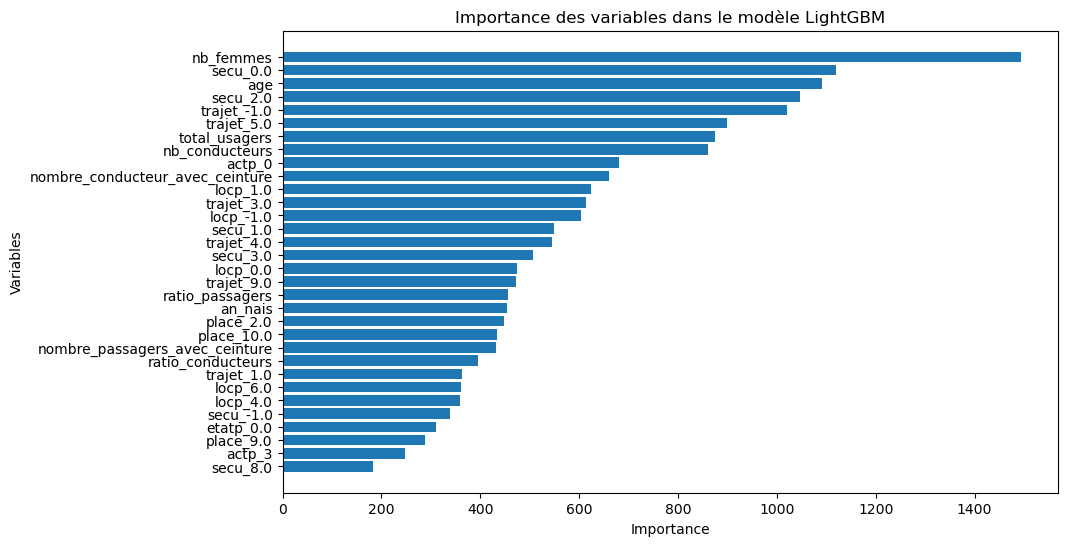

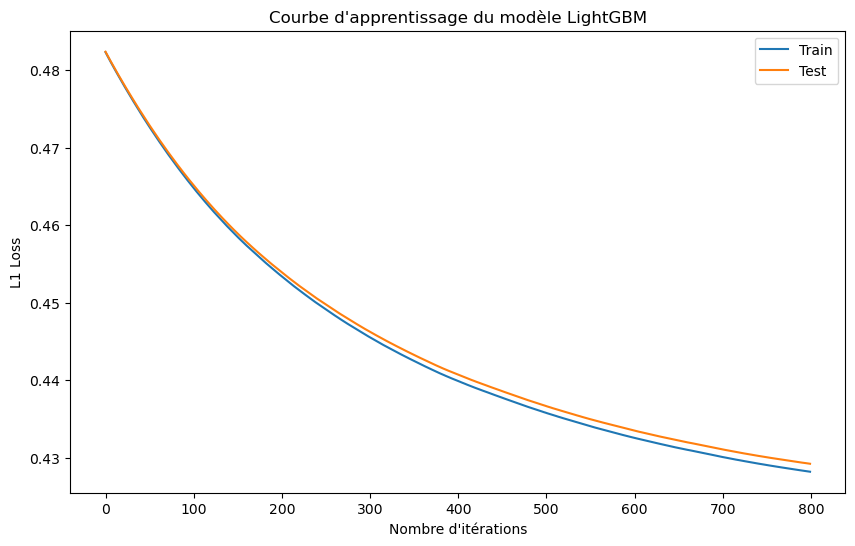

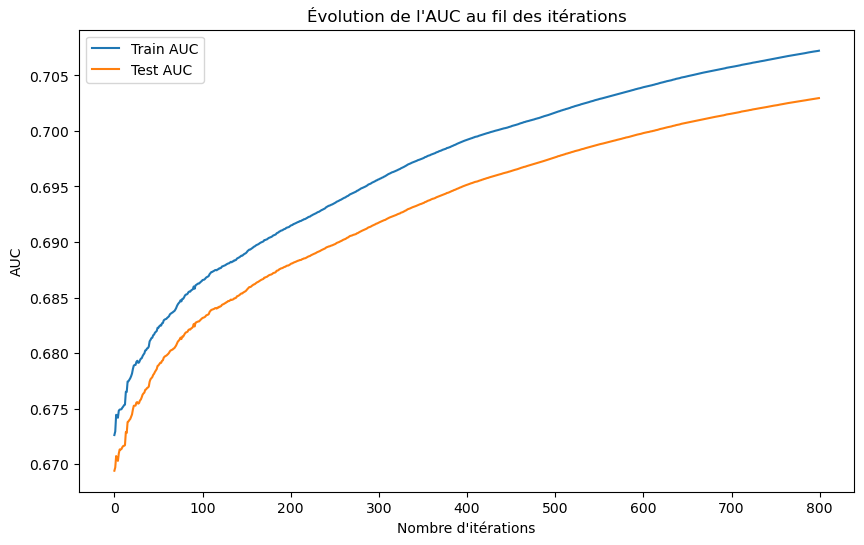

In [207]:
feature_imp_df_final = training_model(lgb_model,X,y)